# Advanced OpenACC: Going Asynchronous (C/C++)

In this self-paced, hands-on lab, we will use advanced [OpenACC](http://openacc.org/) directives to optimize several codes. This lab assumes basic understanding of OpenACC.

Lab created by Jeff Larkin, Justin Luitjens, and Mark Ebersole (Follow [@CUDAHamster](https://twitter.com/@cudahamster) on Twitter)

The following timer counts down to a five minute warning before the lab instance shuts down.  You should get a pop up at the five minute warning reminding you to save your work!

<iframe id="timer" src="timer/timer.html" width="100%" height="120px"></iframe>

---
Before we begin, let's verify [WebSockets](http://en.wikipedia.org/wiki/WebSocket) are working on your system.  To do this, execute the cell block *below* by giving it focus (clicking on it with your mouse), and hitting Ctrl-Enter, or by pressing the play button in the toolbar *above*.  If all goes well, you should see get some output returned below the grey cell.  If not, please consult the [Self-paced Lab Troubleshooting FAQ](https://developer.nvidia.com/self-paced-labs-faq#Troubleshooting) to debug the issue.

In [1]:
print "The answer should be three: " + str(1+2)

The answer should be three: 3


Next let's get information about the GPUs on the server by executing the cell below.

In [2]:
!nvidia-smi

Tue Nov  7 09:11:56 2017       
+------------------------------------------------------+                       
| NVIDIA-SMI 346.46     Driver Version: 346.46         |                       
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GRID K520           On   | 0000:00:03.0     Off |                  N/A |
| N/A   26C    P8    17W / 125W |     10MiB /  4095MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

---
The following video will explain the infrastructure we are using for this self-paced lab, as well as give some tips on it's usage.  If you've never taken a lab on this system before, it's highly recommended that you watch this short video first.<br><br>
<div align="center"><iframe width="640" height="390" src="http://www.youtube.com/embed/ZMrDaLSFqpY" frameborder="0" allowfullscreen></iframe></div>

OpenACC Routine Directive
=========================
Prior to the release of OpenACC 2.0, users wanting to make function calls from within an OpenACC `parallel` or `kernels` region would need to either rely on the compiler to inline the function, or manually inline themselves. This restriction was a significant barrier to many programmers who wanted to accelerate their applications using OpenACC. The `routine` directive allows the programmer to inform the compiler that a particular function will be used within an accelerator region so that both host and device versions of the function will be generated.

The OpenACC `routine` directive is placed at the function declaration and provides the compiler with two important pieces of information: first that a function will be used on the accelerator, and second the level of parallelism (gang, worker, vector, or sequential) at which the function will be used. This second piece of information is important, as it allows the compiler to generate an efficient version of the function that is specific to how the program calls the function. The programmer may also choose to specify `nohost` to inform the compiler that there is no need to generate a CPU version of the function.

Using `routine`
---------------
For the first exercise, we will be accelerating a [mandelbrot set](http://en.wikipedia.org/wiki/Mandelbrot_set) generator. Each point in the mandelbrot set may be independently generated, making the generation of these points a good candidate for OpenACC acceleration. At each point the `mandelbrot` function is used to calculate the color for the given pixel. You will need to modify `main.cpp` below to parallelize the nested loops across all pixels in the image (using either `#pragma acc parallel loop` or `#pragma acc kernels`). Notice that if you build the code without the `routine` directive, the compiler will warn you that the accelerator region has been ignored because of the call to the function `mandelbrot`.

    mandelbrot.cpp:
    main.cpp:
    PGCC-S-0155-Accelerator region ignored; see -Minfo messages  (/opt/pgi/linux86-64/14.6/include/CC/fstream: 15)
    main:
         15, Accelerator region ignored
         19, Accelerator restriction: function/procedure calls are not supported
         20, Accelerator restriction: unsupported call to 'mandelbrot__FiT1'
    PGCC/x86 Linux 14.6-0: compilation completed with severe errors
    
Syntax for the `routine` directive as needed for this exercise is (full details available in the [OpenACC 2.0 specification document](http://www.openacc.org/sites/default/files/OpenACC%202%200.pdf)):

    #pragma acc routine gang|worker|vector|seq

Now, modify `mandelbrot.cpp` to inform the compiler that `mandelbrot` should be built for the accelerator using the `acc routine` pragma. If all goes well, the compile will now generate an accelerator kernel for your loops.

You can edit these files by clicking on the `task0` folder in the left pane of the text editor below, and then choosing your desired file.  Make sure to save the file using the `Save` button within the editor.  This will save the file directly on the GPU instance you're working on.  To compile & run the code, see the instructions below the text editor.

If you click on the green box below, you will see a hint.  Finally, if you get stuck, the soultion is available in the `main_solution.cpp` and `mandelbrot_solution.cpp`.

[Task #0 Hints](#Hint-#1)

<iframe id="task0" src="C/task0" width="100%" height="600px">
  <p>Your browser does not support iframes.</p>
</iframe>

Execute the following cell to compile the program.

In [3]:
!pgc++ -acc -Minfo=accel -fast -ta=tesla -o C/task0/mandelbrot C/task0/mandelbrot.cpp C/task0/main.cpp -IC/task0/

C/task0/mandelbrot.cpp:
mandelbrot(int, int):
      9, Generating acc routine seq
     16, Loop carried scalar dependence for y at line 17
         Loop carried scalar dependence for y at line 18
         Loop carried scalar dependence for x at line 17
         Loop carried scalar dependence for x at line 18
C/task0/main.cpp:
main:
     19, Accelerator kernel generated
         Generating Tesla code
         22, #pragma acc loop gang /* blockIdx.x */
         23, #pragma acc loop vector(128) /* threadIdx.x */
     19, Generating copy(image[:67108864])
     23, Loop is parallelizable


Next, we'll run and time the resulting executable by executing the following cell. 

**NOTE:** If you run this application without any GPU-acceleration, it will take almost a minute to complete.

In [4]:
%%bash
rm -f image.png
time C/task0/mandelbrot
convert image.pgm -scale 600x600 image.png

Time: 2.867092 seconds.



real	0m2.932s
user	0m0.334s
sys	0m0.239s


To see the image generated, run the following cell.

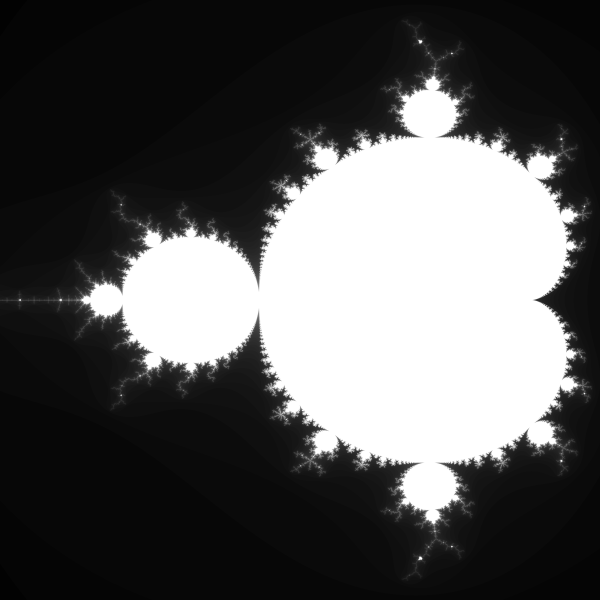

In [5]:
from IPython.core.display import Image
Image('image.png')

As you've hopefully discovered, the mandelbrot routine is a *sequential* routine, meaning that it is contains no parallelism, but rather is called from each point in the image. If it had contained a *vector* loop, we would have declared it as `acc routine vector`. The same is true for `worker` or `gang` routines. Declaring the type of parallelism that a routine contains helps it to understand how to build both the routine and the calling OpenACC region for the device.

## Obtaining a Profile

If you ran the mandelbrot executable with and without OpenACC you know that this first OpenACC version is about 4.2x faster than the non-OpenACC version.  Can we make the OpenACC version run even faster? To determine that we will use the CUDA Visual Profiler which comes standard with the CUDA Toolkit software to get a GPU execution timeline.  To launch the tool please  <a href="/vnc" onclick="window.open(this.href, 'Profiler',
'left=20,top=20,width=1300,height=772,toolbar=1,resizable=0'); return false;">click here</a> which will open a new browser window.  **Note that it may take a few seconds for NVVP to start.**
If the browser-based VNC session does not work you can try either:

* a VNC client and connect to **ec2-54-211-171-253.compute-1.amazonaws.com**:5900 with password **WD2y4LxWr** or
* the NoMachine 4.x or 5.x client to **ec2-54-211-171-253.compute-1.amazonaws.com** using the NX protocol (port 4000) with username **ubuntu** and password **WD2y4LxWr**

If you've never used NVVP before or if you want to read more about you can [click here](https://developer.nvidia.com/nvidia-visual-profiler) for more information.

Click *File -> New Session* to begin a new profiling session.  You'll be presented with a dialog box which allows you to setup the profiling session.  In the **File** Field, click the **Browse** button and navigate to your executable file.  It is located at **`ubuntu/notebook/C/task0`**.  Select **`mandelbrot`** and click **OK** in the bottom right corner.  Then click **Next** and then **Finish** and the profiler will begin by generating a timeline of your executable.  

Your CUDA Visual Profiler timeline should look something like the image below.  You will probably need to zoom in due to the time spent writing the image by using the "+" magnifying glass.  A quicker way is to hold the `ctrl` key and highlight the area to zoom in on with your mouse, then release the `ctrl` key.

<img src="files/step0.png">

The first thing to note from our profile is that although we're faster than the CPU, we're not taking advantage of the fact that the GPU and the PCIe bus can operate independently of each other. Instead we're copying all of our array to the device, operating on the entire image, and then copying it all back to the CPU memory to be written out to file. The NVIDIA Visual Profiler calls this "Low Compute/Copy Overlap." To further speed up this code, we're going to perform a technique known as pipelining. We'll break the work into smaller pieces such that we can be copying one piece to the device, while we compute on another, while we're also copying a completed piece back from the device. By pipelining   the work, we can effectively remove the cost of copying data to and from the device, except for the first and last copies, which cannot be overlapped.

## OpenACC Pipeline - Step 1: Dividing the Work
We're going to implement our pipeline in steps so that we ensure that we keep getting the correct results at each step of the process. For the first step we'll add a loop that breaks the work up into smaller pieces. For your convenience, we've already added a `num_blocks` value that you can use for breaking up your work into even chunks.

For this step, you may find it easier to disable OpenACC while you work on adding the blocking. This will ensure that any bugs introduced into the code are unrelated to the GPU. You can instruct the compiler to ignore OpenACC by removing the `-acc` and `-ta=tesla` compiler flags. Notice now that the compiler no longer gives feedback about generating OpenACC kernels. 

Now start by adding a loop around the existing loop nest for iterating over `num_blocks` worth of chunks. The `acc parallel` directive should remain on the `y` loop, since we do not want to parallelize the chunking look. You will need to change the `y` loop to only loop within the newly introduced chunk. Remember, you should still visit each (X,Y) pixel exactly once. Be sure to rerun the code to make sure that you still generate the same image and in roughly the same amount of time. Once you're satisfied with the results, re-enable OpenACC in your code by adding back the compiler flags. 

[Task #1 Hints](#Task-#1-Hints)

<iframe id="task1" src="C/task1" width="100%" height="600px">
  <p>Your browser does not support iframes.</p>
</iframe>

In [6]:
!pgc++ -acc -Minfo=accel -fast -ta=tesla   -o C/task1/mandelbrot C/task1/mandelbrot.cpp C/task1/solution/main_step2.cpp -IC/task1/ 

C/task1/mandelbrot.cpp:
mandelbrot(int, int):
      9, Generating acc routine seq
     15, Loop carried scalar dependence for y at line 16
         Loop carried scalar dependence for y at line 17
         Loop carried scalar dependence for x at line 16
         Loop carried scalar dependence for x at line 17
C/task1/solution/main_step2.cpp:
main:
     17, Generating create(image[:268435456])
     22, Generating update device(image[block*block_size:block_size])
         Accelerator kernel generated
         Generating Tesla code
         25, #pragma acc loop gang /* blockIdx.x */
         26, #pragma acc loop vector(128) /* threadIdx.x */
         Loop is parallelizable
     31, Generating update self(image[block*block_size:block_size])


Now run the resulting executable.  You should expect the runtime to be similar to the initial OpenACC version.

In [7]:
%%bash
rm -f image.png
time C/task1/mandelbrot
convert image.pgm -scale 600x600 image.png


real	0m19.066s
user	0m0.452s
sys	0m0.761s


Display the generated image to ensure it's the same as before.

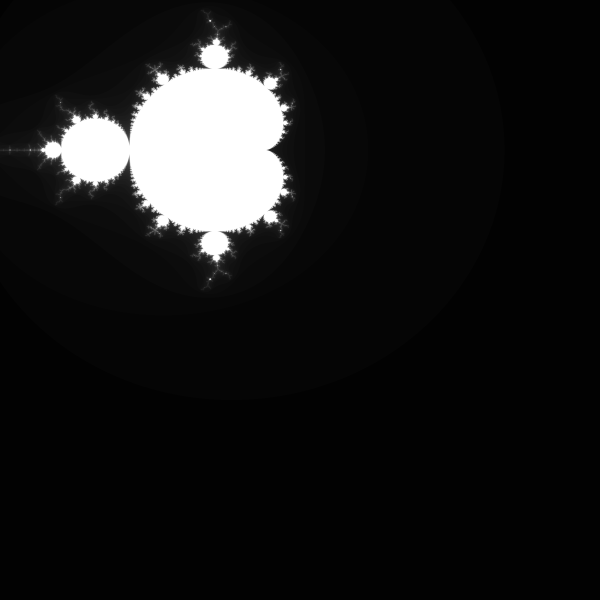

In [8]:
from IPython.core.display import Image
Image('image.png')

## OpenACC Pipeline - Step 2: Optimizing Data Motion

At this point our mandelbrot generator is operating over chunks of data, but we're relying completely upon the OpenACC compiler to handle the movement of data between the CPU and GPU memory spaces. It'd be nice if we could provide the compiler with additional information about how the data is being used so that it could make more intelligent decisions about how to allocate our memory and perform PCIe copies. For this example, let's add an OpenACC `data` region around our chunking loop so that we allocate space for the whole image once and reuse it for the whole image. As a reminder, the syntax for an OpenACC data region is the following:

    #pragma acc data <data-clauses>

For this step, we probably want to use a `create` data clause, since we want to create space for the image, but we still want the contents of each chunk to be copied as it is needed or available. Since the image array is dynamically allocated, you will need to provide the compiler with the _shape_ of the array. This is done with the following syntax: `create(array[starting_index:number_of_elements])`. Add an OpenACC data region around the chunking loop and make sure that you still get the same results.

After adding your data region, we should next be more explicit about how we want our data moved between the host and device. By being more explicit about when and how to move the data we can later make these explicit data motion pragmas asynchronous. We will use the `update` directive to move only the array sections of interest to and from the device for each chunk. The syntax of `acc update` is the following:

    #pragma acc update <self(array[start:count])|device(array[start:count])>
    
In this example the `device` clause is used to copy data from the CPU to the GPU and the `self` clause will be used to copy data from the GPU to the CPU (note: OpenACC 2.0 deprecated the `host` clause in favor of the `self` clause). You may wish to calculate a block size to simplify determining the starting point and count for each `update`. Add `update` pragmas before and after the `y` loop to explicitly copy the array parts of interest to and from the device.

<iframe id="task2" src="C/task2" width="100%" height="600px">
  <p>Your browser does not support iframes.</p>
</iframe>

In [16]:
!pgc++ -acc -Minfo=accel -fast -ta=tesla -o C/task2/mandelbrot C/task2/mandelbrot.cpp C/task2/main_solution.cpp -IC/task2/ 

C/task2/mandelbrot.cpp:
mandelbrot(int, int):
      9, Generating acc routine seq
     15, Loop carried scalar dependence for y at line 16
         Loop carried scalar dependence for y at line 17
         Loop carried scalar dependence for x at line 16
         Loop carried scalar dependence for x at line 17
C/task2/main_solution.cpp:
main:
     19, Generating create(image[:67108864])
     24, Generating update device(image[block*block_size:block_size])
         Accelerator kernel generated
         Generating Tesla code
         27, #pragma acc loop gang /* blockIdx.x */
         28, #pragma acc loop vector(128) /* threadIdx.x */
         Loop is parallelizable
     33, Generating update self(image[block*block_size:block_size])


Now run the resulting executable.  You should expect the runtime to be similar to the initial OpenACC version.

In [17]:
%%bash
rm -f image.png
C/task2/mandelbrot
convert image.pgm -scale 600x600 image.png

Time: 0.510671 seconds.


Display the generated image to ensure it's the same as before.

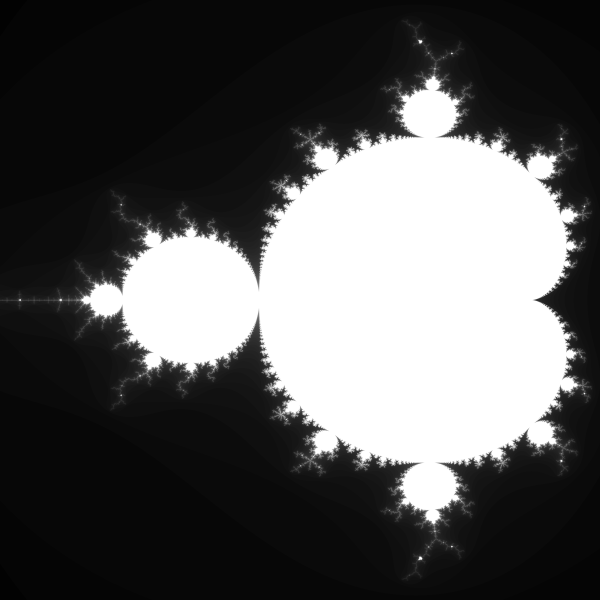

In [18]:
from IPython.core.display import Image
Image('image.png')

Try running this new code in the CUDA Visual Profiler.  If you closed the window, you can open it again by <a href="/vnc" onclick="window.open(this.href, 'Profiler',
'left=20,top=20,width=1300,height=772,toolbar=1,resizable=0'); return false;">clicking here</a>. You should see that the large kernel execution has now been broken up and the PCIe copies no longer happen strictly at the beginning and end of the timeline, but are now mixed in with the GPU computation. 

<img src="files/step2.png">

The next step is to make your operations asynchronous so that they can be overlapped.

## OpenACC Pipeline - Step 3: Going Asynchronous

At this point you are dividing the work into smaller chunks, but because all of the operations are synchronous with the CPU, they must be performed in order and cannot be overlapped. In this step we will use the OpenACC `async` clause on both our data transfers and our computation to inform the OpenACC compiler and runtime that the work can be run without interacting with the CPU. The `async` clause has two forms: the first is without any arguments and the second with some integer number the identify an *asynchronous work queue* for the work. Any OpenACC directive that uses the `async` clause in the first form with be placed on the GPU and then execution on the CPU will continue so that the program can either enqueue more work to the GPU or work on something else. Because the CPU is continuing execution it is necessary to synchronize with the GPU before accessing data that will be copied back, otherwise the CPU may be accessing stale data. To synchronize with the GPU OpenACC has the `wait` directive, which will block the CPU from continuing until all asynchronous work up to that point in the program has completed. The syntax for the `wait` directive is the following:

    #pragma acc wait[(async_id)]

Let's start by adding the `async` clause to all of our `update` directives and also our `parallel loop` (or `kernels` if you used it instead) directives. Since we are now launching the work and data transfers asynchronously from the CPU, we will need to add a `wait` directive after the blocking loop so that everything has completed before we print out the image. If you forget to do this you will likely see a partial image.

**NOTE: we've added the "pin" suboption to "-ta=tesla" to force all memory used by OpenACC to use CUDA Pinned memory, which is required for asynchronous PCIe transfers. This is not strictly required, as the runtime will pin the memory for you, but due to the short runtime of our sample this automatic pinning will result in limited performance improvement. For longer-running applications the cost of automatic pinning will be absorbed into the overall runtime and will not be noticable.**

[Task #3 Hints](#Task-#3-Hints)

<iframe id="task3" src="C/task3" width="100%" height="600px">
  <p>Your browser does not support iframes.</p>
</iframe>

In [25]:
!pgc++ -acc -Minfo=accel -fast -ta=tesla:pin -o C/task3/mandelbrot C/task3/mandelbrot.cpp C/task3/main.cpp -IC/task3/

C/task3/mandelbrot.cpp:
mandelbrot(int, int):
      9, Generating acc routine seq
     15, Loop carried scalar dependence for y at line 16
         Loop carried scalar dependence for y at line 17
         Loop carried scalar dependence for x at line 16
         Loop carried scalar dependence for x at line 17
C/task3/main.cpp:
main:
     19, Generating create(image[:67108864])
     24, Generating update device(image[block*block_size:block_size])
         Accelerator kernel generated
         Generating Tesla code
         27, #pragma acc loop gang /* blockIdx.x */
         28, #pragma acc loop vector(128) /* threadIdx.x */
         Loop is parallelizable
     33, Generating update self(image[block*block_size:block_size])


In [26]:
%%bash
rm -f image.png
time C/task3/mandelbrot
convert image.pgm -scale 600x600 image.png

Time: 0.455702 seconds.



real	0m7.549s
user	0m0.293s
sys	0m0.236s


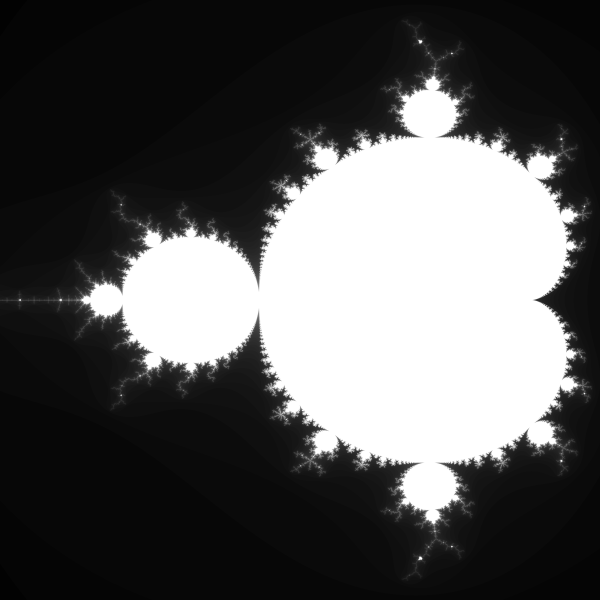

In [27]:
from IPython.core.display import Image
Image('image.png')

If all went well you will still produce the same image as before, but the runtime of your executable will have sped up. If you are not getting the correct image any more, go back and make sure that you have added a `wait` directive before writing the image to a file.

<img src="files/step3.png">

## OpenACC Pipeline - Step 4: Overlapping
Now that we know that we're able to use the GPU asynchronously from the CPU there's one last step to getting overlapping. Because we used the `async` clause without any parameter we're putting all of the work in the same asyncrhonous work queue. Since we know that each chunk can operate independently of the others we can do better than this. There is a second form of the `async` clause which accepts an integer parameter (a *handle*) to identify a work queue. In this form all work with the same *handle* will be placed in the same *work queue*. Work placed in a work queue will always complete in the order it was put into the queue (First-In, First-Out), but operations in different work queues are independent of each other and, therefore, can be run in any order or even simultaneously. Work queues are a way of expressing dependencies in our program. The `wait` directive can also accept a parameter to identify a particular work queue to wait on, which will block the CPU until all work in only the specified work queue has completed. We will not be using this form of the `wait` directive in this example. Edit your code to now pass the block number to the `async` clause. 

<iframe id="task4" src="C/task4" width="100%" height="600px">
  <p>Your browser does not support iframes.</p>
</iframe>

In [31]:
!pgc++ -acc -Minfo=accel -fast -ta=tesla:pin -o C/task4/mandelbrot C/task4/mandelbrot.cpp C/task4/main.cpp -IC/task4/

C/task4/mandelbrot.cpp:
mandelbrot(int, int):
      9, Generating acc routine seq
     15, Loop carried scalar dependence for y at line 16
         Loop carried scalar dependence for y at line 17
         Loop carried scalar dependence for x at line 16
         Loop carried scalar dependence for x at line 17
C/task4/main.cpp:
main:
     19, Generating create(image[:67108864])
     24, Generating update device(image[block*block_size:block_size])
         Accelerator kernel generated
         Generating Tesla code
         27, #pragma acc loop gang /* blockIdx.x */
         28, #pragma acc loop vector(128) /* threadIdx.x */
         Loop is parallelizable
     33, Generating update self(image[block*block_size:block_size])


In [32]:
%%bash
rm -f image.png
time C/task4/mandelbrot
convert image.pgm -scale 600x600 image.png

Time: 0.436606 seconds.



real	0m3.779s
user	0m0.233s
sys	0m0.278s


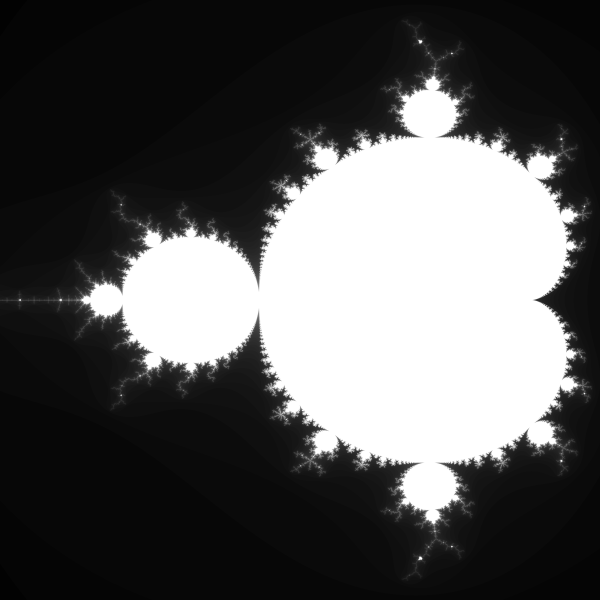

In [33]:
from IPython.core.display import Image
Image('image.png')

Because our executable spends so much time writing the image, you may not see a significant speed-up from the previous version. Go ahead and run the executable in the CUDA Visual Profiler one more time. You should see a timeline that looks something like the picture below. Notice that we are now overlapping all except the first and last PCIe copies. We've essentially made all of the other copies free, since they happen at the same time that the GPU is busy working on other things. It's not always possible to elimate data motion from an application. In these cases overlapping the copy and computation is the next best thing.

<img src="files/step4.png">

By this point you have taken a CPU code, accelerated it with OpenACC, and then optimized the data movement by building up a pipeline of work. The end result is more than a 20X performance improvement compared to the serial code or a 7X improvement over an OpenMP threaded code. 

## Bonus Problem

The optimal pipeline length (number of chunks) will vary from application to application. The best case scenario is to choose a size where there's enough work being done on the GPU that the PCIe transfers will be completely overlapped with the computation. Keep in mind that it's actually possible to copy data to and from the GPU at the same time. Also keep in mind that the computation time may change depending on the particular GPU on which you are running and the PCIe transfer time may vary depending on whether the system supports PCIe version 2 or version 3. Experiment with the number of chunks in your code to see what the best value is for this particular code and GPU. You should also experiment with different image sizes to see if that affects the optimal number of chunks.

## Learn More

If you are interested in learning more about OpenACC, you can use the following resources:

* [openacc.org](http://openacc.org/)
* [OpenACC on CUDA Zone](https://developer.nvidia.com/openacc)
* Search or ask questions on [Stackoverflow](http://stackoverflow.com/questions/tagged/openacc) using the openacc tag
* Get a [30-day trial](http://www.nvidia.com/object/openacc-gpu-directives.html) of the PGI OpenACC compiler *and* visit the PGI support forums at www.pgroup.com/userforum
* Attend an in-depth workshop offered by XSEDE (https://portal.xsede.org/overview) or a commercial provider (see the 'classes' tab at OpenACC.org)

---

<a id="post-lab"></a>
## Post-Lab

Finally, don't forget to save your work from this lab before time runs out and the instance shuts down!!

1. Save this IPython Notebook by going to `File -> Download as -> IPython (.ipynb)` at the top of this window
2. You can execute the following cell block to create a zip-file of the files you've been working on, and download it with the link below.

In [ ]:
%%bash
rm -f openacc_files.zip
zip -r openacc_files.zip task*/*

**After** executing the above zip command, you should be able to download the zip file [here](files/openacc_files.zip)

<a id="FAQ"></a>
---
# Lab FAQ

Q: I'm encountering issues executing the cells, or other technical problems?<br>
A: Please see [this](https://developer.nvidia.com/self-paced-labs-faq#Troubleshooting) infrastructure FAQ.

## Hints

---

### Task #0 Hints

#### Hint #1
Since the `mandlebrot` function is being called for each pixel, it should be declared a `seq` procedure.

[Return to Task #0](#Using-routine)

---

### Task #1 Hints

#### Hint #1
Add a loop over chunks around the existing loop nest and figure out the value for `y` according to the chunk number and size.

#### Hint #2
Calculate the size of each chunk based on the image size and number of chunks, then use that value to find the starting and ending values for the `y` loop.

#### Hint #3
Use the `acc update device` and `acc update self` directives to copy a portion of the image array to and from the device, respectively.

[Return to Task #1](#OpenACC-Pipeline---Step-1:-Dividing-the-Work)

---
### Task #3 Hints

#### Hint #1
Don't forget to place a `wait` before outputting the image to ensure that all of the data has been copied back from the GPU before writing to the file.

[Return to Task #3](#OpenACC-Pipeline---Step-3:-Going-Asynchronous)

<style>
p.hint_trigger{
  margin-bottom:7px;
  margin-top:-5px;
  background:#64E84D;
}
.toggle_container{
  margin-bottom:0px;
}
.toggle_container p{
  margin:2px;
}
.toggle_container{
  background:#f0f0f0;
  clear: both;
  font-size:100%;
}
</style>
<script>
$("p.hint_trigger").click(function(){
   $(this).toggleClass("active").next().slideToggle("normal");
});
   
$(".toggle_container").hide();
</script>